In [1]:
import os, time, itertools, sys, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from copy import deepcopy
from bs4 import BeautifulSoup
from pybaseball import *
sys.path.append('/home/dcooper/rockies/RockiesAnalysis/')
from utils.analysis.load_pitch_data import load_pitch_data
from utils.analysis.home_road_splits import get_day_split_inds
import warnings
warnings.filterwarnings("ignore")

/home/dcooper/anaconda3/envs/rockies/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Load pitch data

In [2]:
# Load pitch data from savant
pitch_df = load_pitch_data(start_year=2021, end_year=2025)
pitches = pitch_df['pitch_name'].unique()
pitch_df.shape, pitches

((3567640, 118),
 array(['4-Seam Fastball', 'Slider', 'Curveball', 'Sinker', 'Split-Finger',
        'Cutter', 'Changeup', 'Knuckle Curve', 'Sweeper', nan, 'Slurve',
        'Other', 'Slow Curve', 'Eephus', 'Pitch Out', 'Knuckleball',
        'Screwball', 'Forkball', 'Unknown'], dtype=object))

In [3]:
# Get events
event_df = pitch_df[~pitch_df['events'].isna()]
event_df.shape

(914786, 118)

In [4]:
# Get BIP
BIP_df = pitch_df[pitch_df['type'] == 'X']
BIP_df.shape

(619298, 118)

## Get home/road split days

In [5]:
years = [2025]
batting_game_logs = []
day_split_inds = []
for i, year in enumerate(years):

    # Get game logs
    batting_logs = team_game_logs(year, 'COL', 'batting')
    batting_game_logs.append(batting_logs)

    # Get day split indices
    day_split_inds.append(get_day_split_inds(batting_logs))

In [6]:
for i, (h,a) in enumerate(zip(day_split_inds[0][0], day_split_inds[0][1])):
    print('Day', i+1, len(h), len(a))

Day 1 13 14
Day 2 13 14
Day 3 13 14
Day 4 12 12
Day 5 12 11
Day 6 12 11
Day 7 3 3
Day 8 2 1
Day 9 1 1
Day 10 0 0
Day 11 0 0


In [7]:
batting_logs.head()

,Gtm,Date,Home,Opp,Score: Rslt,Score: RS,Score: RA,Score: Inn,Batting Stats: PA,Batting Stats: AB,...,Batting Stats: SH,Batting Stats: SF,Batting Stats: ROE,Batting Stats: IBB,Batting Stats: BAbip,Batting Stats: LOB,Batting Stats: #,Opp Starter: Player,Opp Starter: T,Opp Starter: GmSc
0,1,2025-03-28,@,TBR,L,2,3,9,37,32,...,0,1,1,0,.333,8,10,Ryan Pepiot,R,61
1,2,2025-03-29,@,TBR,W,2,1,9,33,33,...,0,0,0,0,.250,4,11,Zack Littell,R,67
2,3,2025-03-30,@,TBR,L,4,6,9,36,35,...,0,0,0,0,.333,5,11,Taj Bradley,R,61
3,4,2025-03-31,@,PHI,L,1,6,9,37,33,...,0,0,0,0,.263,9,11,Cristopher Sánchez,L,61
4,5,2025-04-02,@,PHI,L,1,5,9,33,30,...,0,0,0,0,.200,5,11,Zack Wheeler,R,77


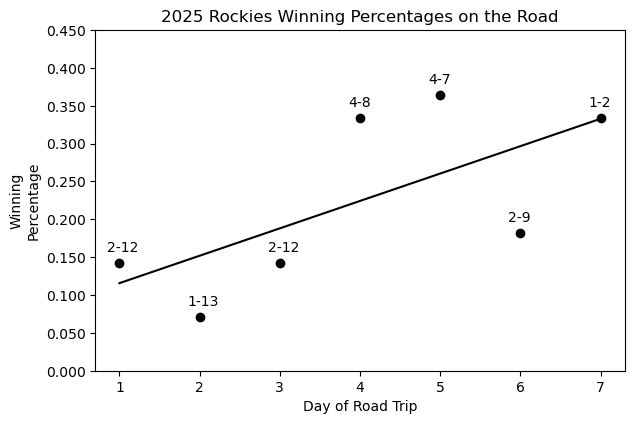

In [8]:
from scipy.stats import linregress
lim = 7
wins = np.zeros(lim, dtype=int)
losses = np.zeros(lim, dtype=int)
for i, (h,a) in enumerate(zip(day_split_inds[0][0][:lim], day_split_inds[0][1][:lim])):
    away_results = batting_logs.iloc[a]['Score: Rslt'].to_numpy()
    if away_results.shape[0] > 2:
        _, (L, W) = np.unique(away_results, return_counts=True)
        wins[i], losses[i] = W, L
        # print(i+1, W, L)

fig, ax = plt.subplots(figsize=(6,4))
# ax.bar(np.arange(lim)+1-0.15, height=wins, width=0.3, color='purple', label='W')
# ax.bar(np.arange(lim)+1+0.15, height=losses, width=0.3, color='silver', label='L')
winning_percs = np.zeros(len(wins))
for i, (w, l) in enumerate(zip(wins, losses)):
    winning_perc = w / (w + l)
    winning_percs[i] = winning_perc
    ax.text(i+0.85, winning_perc+.015, s=f'{w}-{l}')

plt.scatter(np.arange(len(wins))+1, winning_percs, color='k')
m, b, r, _, _ = linregress(np.arange(len(wins))+1, winning_percs)
x = np.arange(len(wins))
plt.plot(x+1, (x+1)*m + b, color='k')

ax.set_ylim(0, 0.45)
fig.tight_layout()
ax.set_ylabel('Winning\nPercentage')
ax.set_xlabel('Day of Road Trip')

import matplotlib.ticker as tkr
formatter = tkr.FuncFormatter(lambda x, _: f'{x:.3f}') 

# Apply the formatter to the y-axis major ticks
ax.yaxis.set_major_formatter(formatter)
ax.set_title('2025 Rockies Winning Percentages on the Road')

plt.show()



## Methods

In [9]:
# Parse player
def get_batter(df, first=None, last=None, playerid=None, year=None):

    # Get player id
    if playerid is None:
        playerid = playerid_lookup(last, first).loc[0, 'key_mlbam']

    # Filter df
    player_df = df.loc[df['batter'] == playerid]
    if year is not None:
        year_inds = [i for i, date in enumerate(player_df['game_date'].to_list()) if int(date.split('-')[0]) == year] 
        player_df = player_df.iloc[year_inds]

    return player_df
        

In [10]:
# Batted ball methods
def get_hard_hit_rate(df):
    """
    Assumes df is only of BIP.
    """
    try:
        return 100 * (df.loc[df['launch_speed'] >= 95.0].shape[0] / df.shape[0])
    except ZeroDivisionError:
        return np.nan

def is_barrel(exit_velocity: float, launch_angle: float) -> bool:
    """
    Determine whether a batted ball is a Statcast 'barrel'.

    Parameters
    ----------
    exit_velocity : float
        Exit velocity in mph.
    launch_angle : float
        Launch angle in degrees.

    Returns
    -------
    bool
        True if the batted ball is classified as a barrel, False otherwise.
    """
    EVs = np.arange(98,116)
    deg_uppers = np.linspace(30,50,EVs.shape[0])
    deg_lowers = np.linspace(26,8,EVs.shape[0])

    if exit_velocity >=98 and exit_velocity <=116:
        deg_idx = np.where(np.abs(EVs - exit_velocity) == np.abs(EVs - exit_velocity).min())[0][0]
    elif exit_velocity > 116:
        deg_idx = -1
    else:
        return False

    if launch_angle >= deg_lowers[deg_idx] and launch_angle <= deg_uppers[deg_idx]:
        return True
    else:
        return False

def get_barrel_rate(df):
    """
    Assumes df is only of BIP.
    """
    # Get number of barrels
    barrels = np.array([is_barrel(ls, la) for ls, la in zip(df['launch_speed'].to_numpy(), df['launch_angle'].to_numpy())]).sum()
    try:
        return 100 * (barrels / df.shape[0])
    except ZeroDivisionError:
        return np.nan    

def get_FB_rate(df):
    """
    Assumes df is only of BIP.
    """
    try:
        return 100 * (df.loc[df['bb_type'] == 'fly_ball'].shape[0] / df.shape[0])
    except ZeroDivisionError:
        return np.nan

def get_GB_rate(df):
    """
    Assumes df is only of BIP.
    """
    try:
        return 100 * (df.loc[df['bb_type'] == 'ground_ball'].shape[0] / df.shape[0])
    except ZeroDivisionError:
        return np.nan
        
def get_LD_rate(df):
    """
    Assumes df is only of BIP.
    """
    try:
        return 100 * (df.loc[df['bb_type'] == 'line_drive'].shape[0] / df.shape[0])
    except ZeroDivisionError:
        return np.nan

def get_SO_rate(df):
    """
    Assumes df is only of events.
    """
    try:
        return 100 * (df.loc[df['events'] == 'strikeout'].shape[0] / df.shape[0])
    except ZeroDivisionError:
        return np.nan

def get_BB_rate(df):
    """
    Assumes df is only of events.
    """
    try:
        return 100 * (df.loc[df['events'] == 'walk'].shape[0] / df.shape[0])
    except ZeroDivisionError:
        return np.nan

def get_mean_launch_speed_pitch_group(df, pitch_group):
    """
    """
    df = df.loc[df['pitch_name'].isin(pitch_group)]
    return df['launch_speed'].mean()

def get_mean_launch_angle_pitch_group(df, pitch_group):
    """
    """
    df = df.loc[df['pitch_name'].isin(pitch_group)]
    return df['launch_angle'].mean()

In [11]:
# Set pitch groups
fastballs = ['4-Seam Fastball', 'Sinker', 'Cutter']
breaking_balls = ['Slider', 'Curveball', 'Knuckle Curve', 'Sweeper', 'Slurve', 'Slow Curve']
changeups = ['Changeup']

## Get Splits

In [12]:
# Get batters
year = 2025
lim = 6
team_batting = team_batting_bref(team='COL', year=year)
year_log = batting_game_logs[0]

# Set regular players
players = ['Hunter Goodman', 'Jordan Beck', 'Brenton Doyle', 'Ezequiel Tovar', 'Tyler Freeman', 'Mickey Moniak']

# Iterate through batters
away_BIP_counts = np.zeros((len(players), lim))
home_hard_hit_rates = np.zeros((len(players), lim))
away_hard_hit_rates = np.zeros((len(players), lim))
home_barrell_rates = np.zeros((len(players), lim))
away_barrell_rates = np.zeros((len(players), lim))
home_FB_rates = np.zeros((len(players), lim))
away_FB_rates = np.zeros((len(players), lim))
home_GB_rates = np.zeros((len(players), lim))
away_GB_rates = np.zeros((len(players), lim))
home_LD_rates = np.zeros((len(players), lim))
away_LD_rates = np.zeros((len(players), lim))
home_SO_rates = np.zeros((len(players), lim))
away_SO_rates = np.zeros((len(players), lim))
home_BB_rates = np.zeros((len(players), lim))
away_BB_rates = np.zeros((len(players), lim))
away_fastball_EV = np.zeros((len(players), lim))
away_breaking_ball_EV = np.zeros((len(players), lim))
away_fastball_LA = np.zeros((len(players), lim))
away_breaking_ball_LA = np.zeros((len(players), lim))
for i, player in enumerate(players):

    # Get name
    first, last = player.split()  

    # Get player dataframes
    player_BIP_df = get_batter(BIP_df, last=last, first=first, year=year)
    player_event_df = get_batter(event_df, last=last, first=first, year=year)

    # # Iterate through home stands
    # for j, year_home_inds in enumerate(day_split_inds[0][0][:lim]):

    #     # Get home dates
    #     home_day_dates = year_log['Date'].to_numpy()[year_home_inds]

    #     # Get player dataframes for specific dates
    #     BIP_keep_inds = [x for x, date in enumerate(player_BIP_df['game_date'].to_list()) if date in home_day_dates]
    #     player_BIP_home_day_df = player_BIP_df.iloc[BIP_keep_inds]

    #     # Get hard hit/barrel percentages
    #     home_hard_hit_rates[i,j] = get_hard_hit_rate(player_BIP_home_day_df)
    #     home_barrell_rates[i,j] = get_barrel_rate(player_BIP_home_day_df)
    #     home_FB_rates[i,j] = get_FB_rate(player_BIP_home_day_df)
    #     home_GB_rates[i,j] = get_GB_rate(player_BIP_home_day_df)
    #     home_LD_rates[i,j] = get_LD_rate(player_BIP_home_day_df)

    # Iterate through road trips    
    for j, year_away_inds in enumerate(day_split_inds[0][1][:lim]):

        # Get home dates
        away_day_dates = year_log['Date'].to_numpy()[year_away_inds]

        # Get player dataframes for specific dates
        BIP_keep_inds = [x for x, date in enumerate(player_BIP_df['game_date'].to_list()) if date in away_day_dates]
        player_BIP_away_day_df = player_BIP_df.iloc[BIP_keep_inds]
        event_keep_inds = [x for x, date in enumerate(player_event_df['game_date'].to_list()) if date in away_day_dates]
        player_event_away_day_df = player_event_df.iloc[event_keep_inds]

        # Get hard hit/barrel percentages
        away_hard_hit_rates[i,j] = get_hard_hit_rate(player_BIP_away_day_df)
        away_barrell_rates[i,j] = get_barrel_rate(player_BIP_away_day_df)
        away_FB_rates[i,j] = get_FB_rate(player_BIP_away_day_df)
        away_GB_rates[i,j] = get_GB_rate(player_BIP_away_day_df)
        away_LD_rates[i,j] = get_LD_rate(player_BIP_away_day_df)
        away_BIP_counts[i,j] = player_BIP_away_day_df.shape[0]
        away_SO_rates[i,j] = get_SO_rate(player_event_away_day_df)
        away_BB_rates[i,j] = get_BB_rate(player_event_away_day_df)
        away_fastball_EV[i,j] = get_mean_launch_speed_pitch_group(player_BIP_away_day_df, fastballs)
        away_breaking_ball_EV[i,j] = get_mean_launch_speed_pitch_group(player_BIP_away_day_df, breaking_balls)
        away_breaking_ball_LA[i,j] = get_mean_launch_angle_pitch_group(player_BIP_away_day_df, breaking_balls)
        away_fastball_LA[i,j] = get_mean_launch_angle_pitch_group(player_BIP_away_day_df, fastballs)

Gathering player lookup table. This may take a moment.


## Plots

### Plot mean hard hit rate and barrel rate

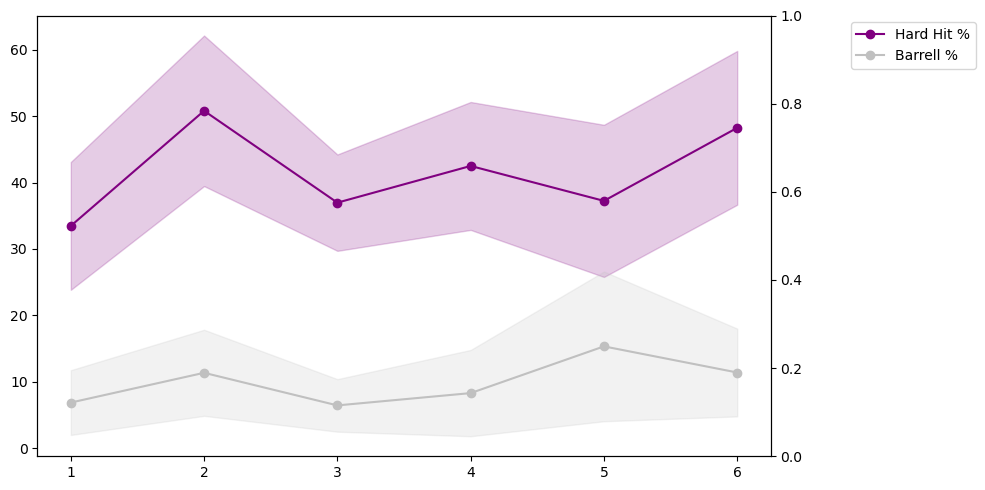

In [13]:
# Plot
fig, ax = plt.subplots(1, figsize=(10, 5))

# Plot means
ax.plot(np.arange(1, lim+1), away_hard_hit_rates.mean(axis=0),  label='Hard Hit %', color='purple', marker='o')
ax.fill_between(np.arange(1, lim+1), away_hard_hit_rates.mean(axis=0) - away_hard_hit_rates.std(axis=0), away_hard_hit_rates.mean(axis=0) + away_hard_hit_rates.std(axis=0), color='purple', alpha=0.2)
ax2 = ax.twinx()
ax.plot(np.arange(1, lim+1), away_barrell_rates.mean(axis=0),  label='Barrell %', color='silver', marker='o')
ax.fill_between(np.arange(1, lim+1), away_barrell_rates.mean(axis=0) - away_barrell_rates.std(axis=0), away_barrell_rates.mean(axis=0) + away_barrell_rates.std(axis=0), color='silver', alpha=0.2)


ax.legend(bbox_to_anchor=(1.1,1))
fig.tight_layout()
plt.show()

### Plot player sample sizes

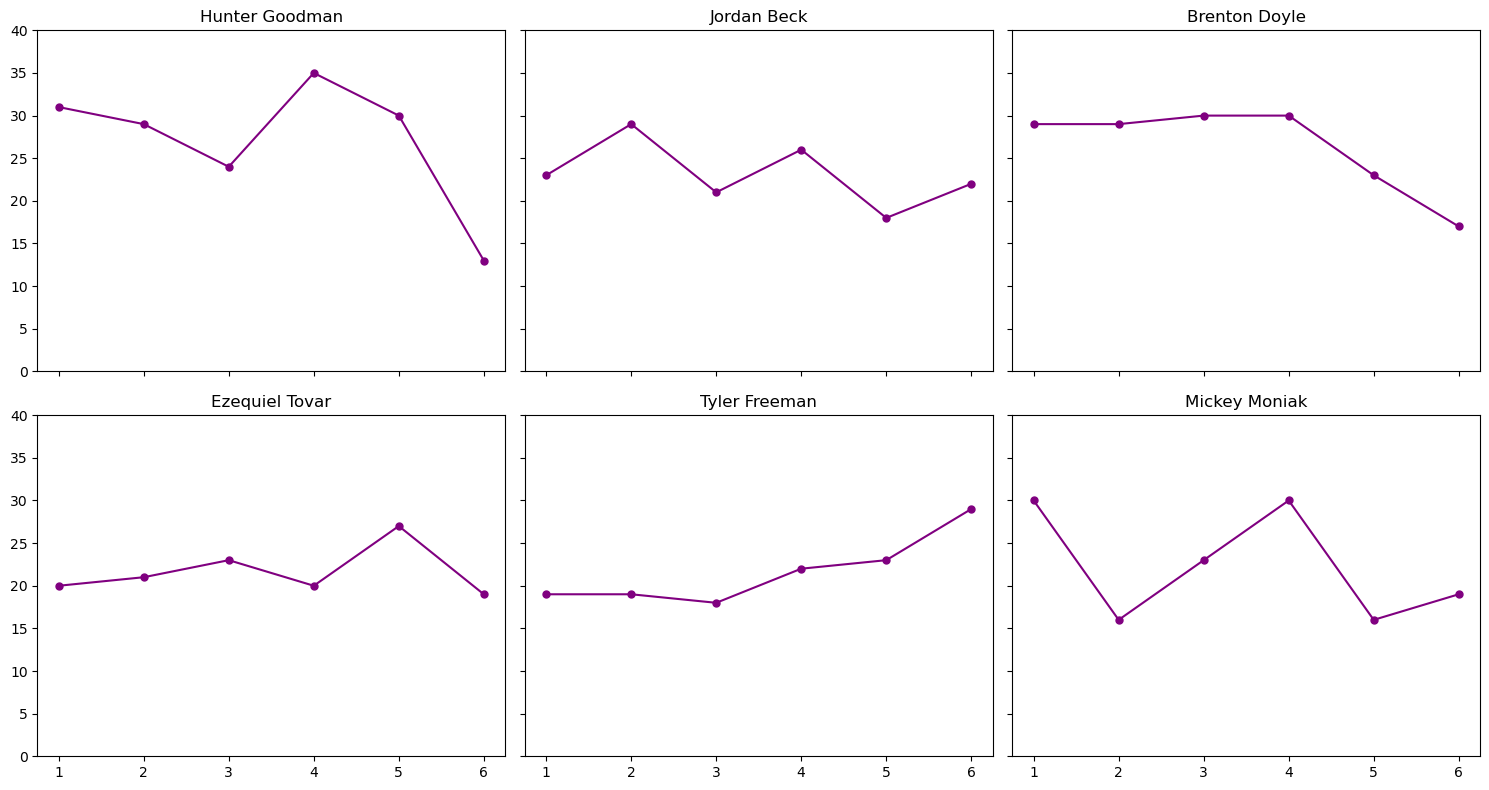

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, (player, ax) in enumerate(zip(players, axs.flatten())):

    # Get name
    first, last = player.split()

    # Add to plot
    l1 = ax.plot(np.arange(1, lim+1), away_BIP_counts[i], color='purple', marker='o', markersize=5)

    # Set other stuff
    ax.set_ylim(0, 40)
    ax.set_title(player)
    ax.label_outer()

fig.tight_layout()
plt.show()

### Plot player barrel and hard hit rates

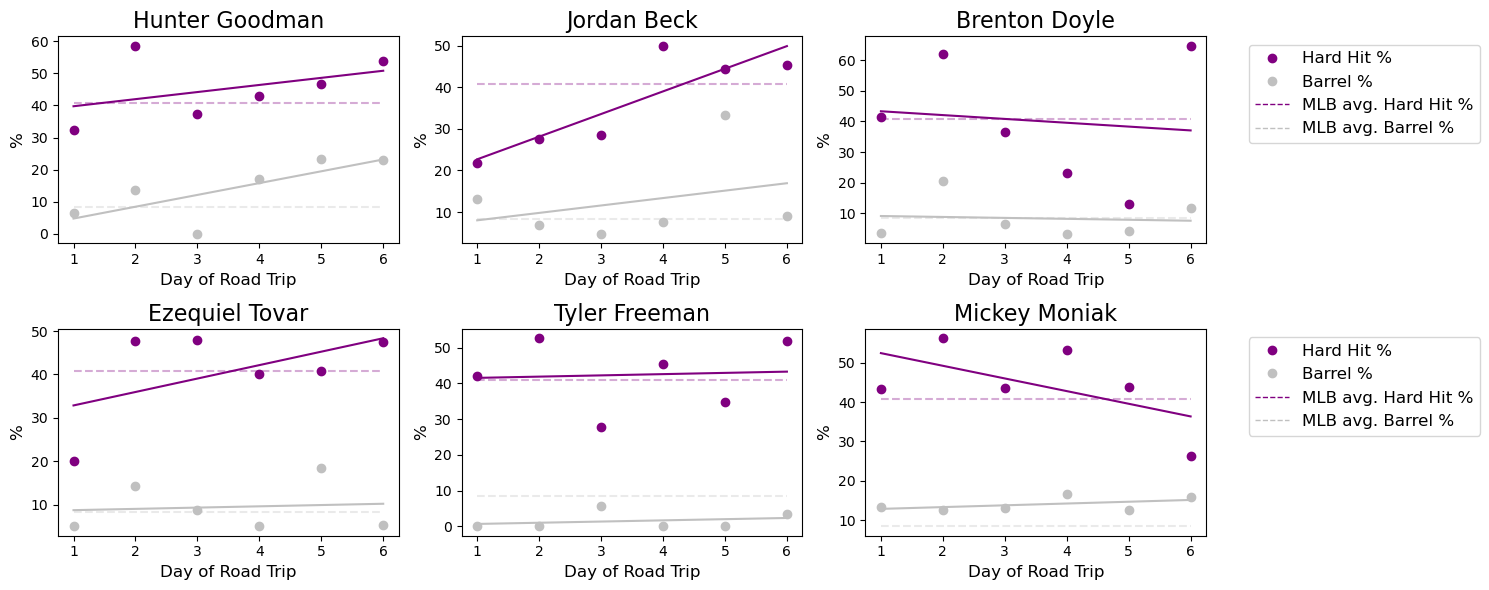

In [15]:
from matplotlib.lines import Line2D
from scipy.stats import linregress

custom_legend_elements = [
    Line2D([0], [0], color='purple', lw=0, label='Hard Hit %', marker='o'),
    Line2D([0], [0], color='silver', lw=0, label='Barrel %', marker='o'),
    Line2D([0], [0], color='purple', lw=1, linestyle='dashed', label='MLB avg. Hard Hit %'),
    Line2D([0], [0], color='silver', lw=1, linestyle='dashed', label='MLB avg. Barrel %'),
]

fig, axs = plt.subplots(2, 3, figsize=(15, 6))
for i, (player, ax) in enumerate(zip(players, axs.flatten())):

    # Get name
    first, last = player.split()

    # Add to plot
    x = np.arange(1, lim+1)
    l1 = ax.scatter(x, away_hard_hit_rates[i], color='purple', marker='o')
    m, b, _, _, _ = linregress(x, away_hard_hit_rates[i])
    ax.plot(x, m*x+b, color='purple')
    # for j, y in enumerate(away_hard_hit_rates[i]):
        # ax.vlines(j+1.005, y, m*(j+1)+b, color='purple', linestyle='dotted')
    
    l2 = ax.scatter(np.arange(1, lim+1), away_barrell_rates[i], color='silver', marker='o')
    m, b, _, _, _ = linregress(x, away_barrell_rates[i])
    ax.plot(x, m*x+b, color='silver')
    # for j, y in enumerate(away_barrell_rates[i]):
        # ax.vlines(j+1.005, y, m*(j+1)+b, color='silver', linestyle='dotted')

    # Set other stuff
    l3 = ax.hlines(40.9, 1, lim, alpha=0.33, linestyle='dashed', color='purple')
    l4 = ax.hlines(8.4, 1, lim, alpha=0.33, linestyle='dashed', color='silver')
    # ax.set_ylim(-5, 80)
    ax.set_title(player, fontsize=16)
    ax.set_ylabel('%', fontsize=12)
    ax.set_xlabel('Day of Road Trip', fontsize=12)
    # ax.label_outer()
    if i%3==2:
        if i == 8:
            ax.legend(handles=custom_legend_elements, bbox_to_anchor=(1.1,1), fontsize=12, facecolor='white')
        else:
            ax.legend(handles=custom_legend_elements, bbox_to_anchor=(1.1,1), fontsize=12, facecolor='white')

fig.tight_layout()
plt.show()

In [16]:
away_barrell_rates[0]

array([ 6.4516129 , 13.79310345,  0.        , 17.14285714, 23.33333333,
       23.07692308])

### Plot player FB,GB,LD rates

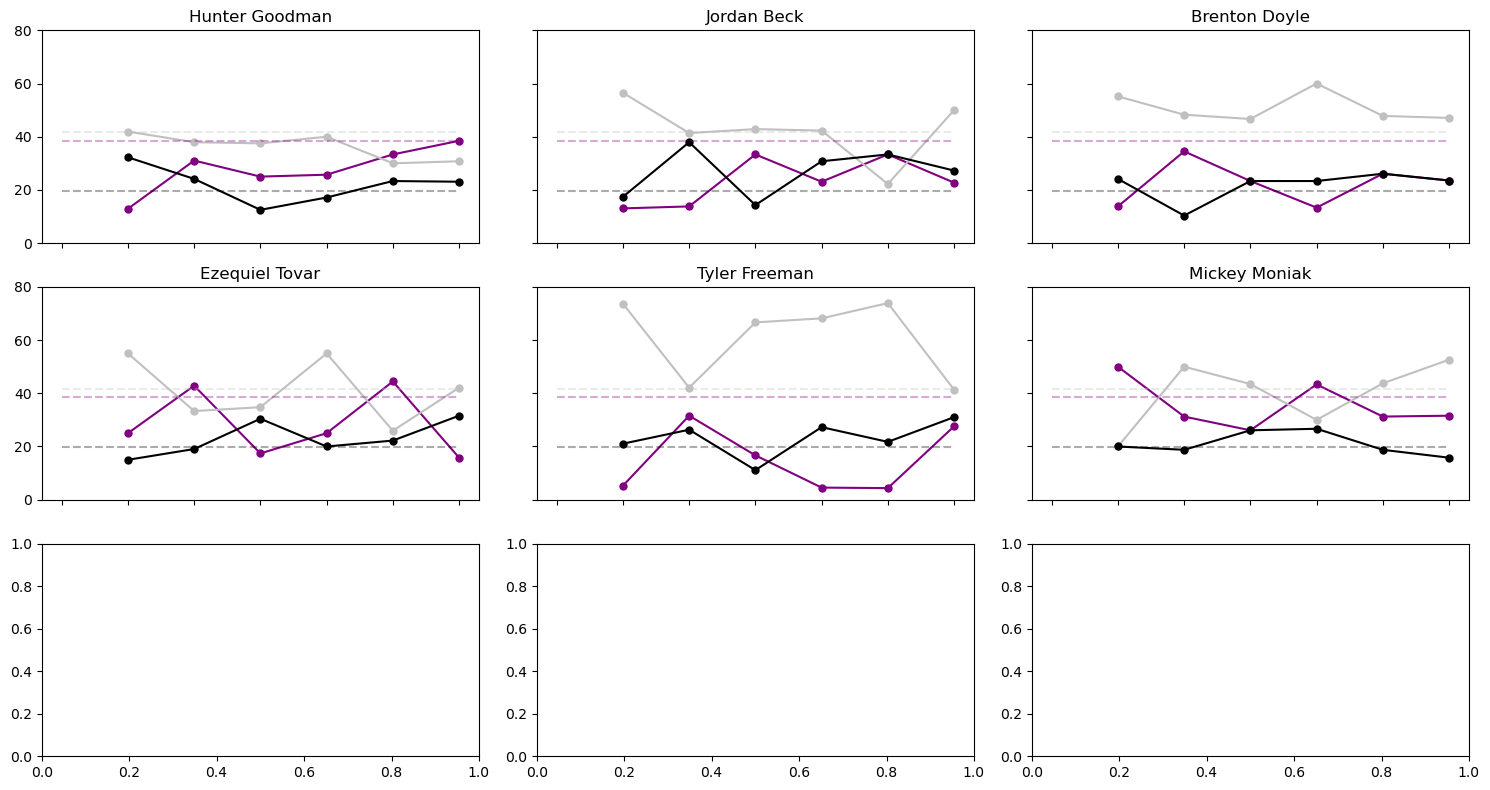

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(15, 8))
for i, (player, ax) in enumerate(zip(players, axs.flatten())):

    # Get name
    first, last = player.split()

    # Add to plot
    l1 = ax.plot(np.arange(1, lim+1), away_FB_rates[i], color='purple', marker='o', markersize=5)
    l2 = ax.plot(np.arange(1, lim+1), away_GB_rates[i], color='silver', marker='o', markersize=5)
    l2 = ax.plot(np.arange(1, lim+1), away_LD_rates[i], color='black', marker='o', markersize=5)

    # Set other stuff
    l3 = ax.hlines(38.5, 0, lim, alpha=0.33, linestyle='dashed', color='purple')
    l4 = ax.hlines(41.8, 0, lim, alpha=0.33, linestyle='dashed', color='silver')
    l5 = ax.hlines(19.7, 0, lim, alpha=0.33, linestyle='dashed', color='black')

    ax.set_ylim(0, 80)
    ax.set_title(player)
    ax.label_outer()
    ax2.label_outer()

fig.tight_layout()
plt.show()

### Plot player SO and BB rates

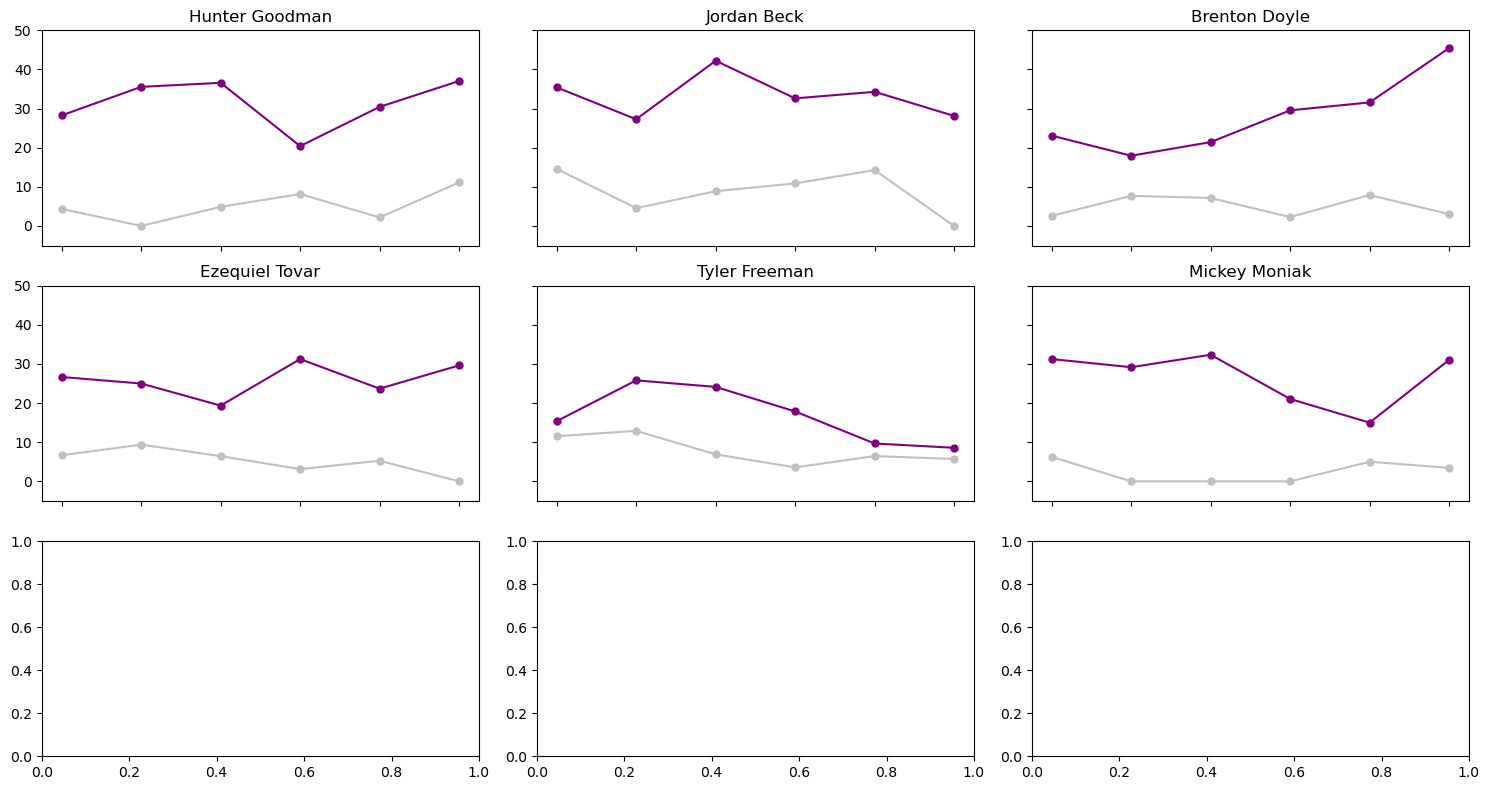

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(15, 8))
for i, (player, ax) in enumerate(zip(players, axs.flatten())):

    # Get name
    first, last = player.split()

    # Add to plot
    l1 = ax.plot(np.arange(1, lim+1), away_SO_rates[i], color='purple', marker='o', markersize=5)
    l2 = ax.plot(np.arange(1, lim+1), away_BB_rates[i], color='silver', marker='o', markersize=5)

    # Set other stuff
    # l3 = ax.hlines(38.5, 0, lim, alpha=0.33, linestyle='dashed', color='purple')
    # l4 = ax.hlines(41.8, 0, lim, alpha=0.33, linestyle='dashed', color='silver')

    ax.set_ylim(-5, 50)
    ax.set_title(player)
    ax.label_outer()
    ax2.label_outer()

fig.tight_layout()
plt.show()

### Plot Pitch Types EV

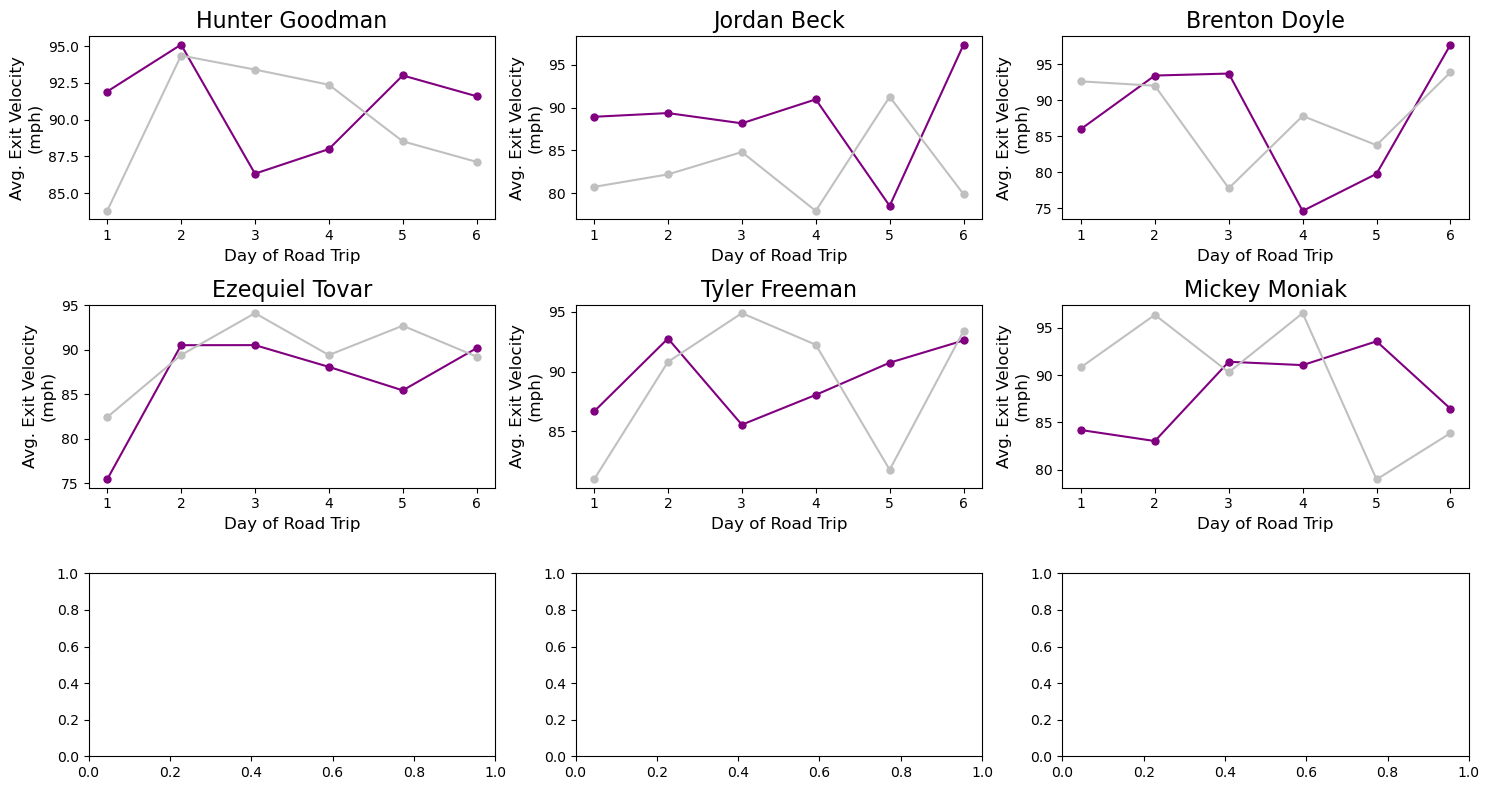

In [19]:
from matplotlib.lines import Line2D

custom_legend_elements = [
    Line2D([0], [0], color='purple', lw=1, label='Hard Hit %'),
    Line2D([0], [0], color='silver', lw=1, label='Barrel %'),
    Line2D([0], [0], color='purple', lw=1, linestyle='dashed', label='MLB avg. Hard Hit %'),
    Line2D([0], [0], color='silver', lw=1, linestyle='dashed', label='MLB avg. Barrel %'),
]

fig, axs = plt.subplots(3, 3, figsize=(15, 8))
for i, (player, ax) in enumerate(zip(players, axs.flatten())):

    # Get name
    first, last = player.split()

    # Add to plot
    ax.plot(np.arange(1, lim+1), away_fastball_EV[i], color='purple', marker='o', markersize=5)
    ax.plot(np.arange(1, lim+1), away_breaking_ball_EV[i], color='silver', marker='o', markersize=5)
    # ax.plot(np.arange(1, lim+1), away_changeup_EV[i], color='black', marker='o', markersize=5)

    # Set other stuff
    # l3 = ax.hlines(40.9, 1, lim, alpha=0.33, linestyle='dashed', color='purple')
    # l4 = ax.hlines(8.4, 1, lim, alpha=0.33, linestyle='dashed', color='silver')
    # ax.set_ylim(65,110)
    ax.set_title(player, fontsize=16)
    ax.set_ylabel('Avg. Exit Velocity\n(mph)', fontsize=12)
    ax.set_xlabel('Day of Road Trip', fontsize=12)
    # ax.label_outer()
    # if i%3==2:
    #     if i == 8:
    #         ax.legend(handles=custom_legend_elements, bbox_to_anchor=(1.1,1), fontsize=12)
    #     else:
    #         ax.legend(handles=custom_legend_elements, bbox_to_anchor=(1.1,1), fontsize=12)

fig.tight_layout()
plt.show()

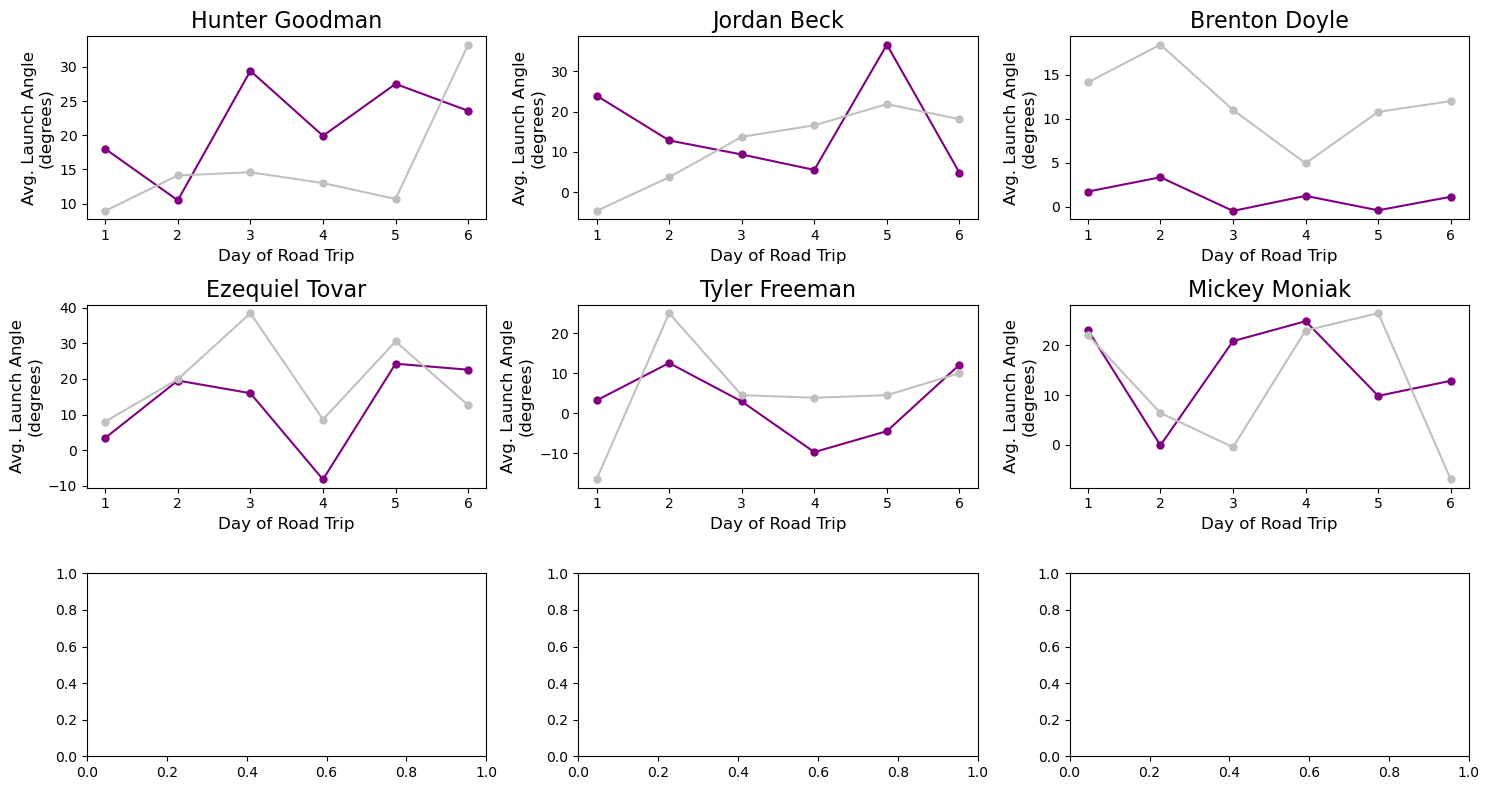

In [20]:
from matplotlib.lines import Line2D

custom_legend_elements = [
    Line2D([0], [0], color='purple', lw=1, label='Hard Hit %'),
    Line2D([0], [0], color='silver', lw=1, label='Barrel %'),
    Line2D([0], [0], color='purple', lw=1, linestyle='dashed', label='MLB avg. Hard Hit %'),
    Line2D([0], [0], color='silver', lw=1, linestyle='dashed', label='MLB avg. Barrel %'),
]

fig, axs = plt.subplots(3, 3, figsize=(15, 8))
for i, (player, ax) in enumerate(zip(players, axs.flatten())):

    # Get name
    first, last = player.split()

    # Add to plot
    ax.plot(np.arange(1, lim+1), away_fastball_LA[i], color='purple', marker='o', markersize=5)
    ax.plot(np.arange(1, lim+1), away_breaking_ball_LA[i], color='silver', marker='o', markersize=5)
    # ax.plot(np.arange(1, lim+1), away_changeup_EV[i], color='black', marker='o', markersize=5)

    # Set other stuff
    # l3 = ax.hlines(40.9, 1, lim, alpha=0.33, linestyle='dashed', color='purple')
    # l4 = ax.hlines(8.4, 1, lim, alpha=0.33, linestyle='dashed', color='silver')
    # ax.set_ylim(-20,55)
    ax.set_title(player, fontsize=16)
    ax.set_ylabel('Avg. Launch Angle\n(degrees)', fontsize=12)
    ax.set_xlabel('Day of Road Trip', fontsize=12)
    # ax.label_outer()
    # if i%3==2:
    #     if i == 8:
    #         ax.legend(handles=custom_legend_elements, bbox_to_anchor=(1.1,1), fontsize=12)
    #     else:
    #         ax.legend(handles=custom_legend_elements, bbox_to_anchor=(1.1,1), fontsize=12)

fig.tight_layout()
plt.show()

### Goodman Launch Angle

In [21]:
player_BIP_df = get_batter(BIP_df, last='Goodman', first='Hunter', year=year)

# Iterate through road trips    
goodman_fastballs = pd.DataFrame(columns=['Day', 'LA'])
for i, year_away_inds in enumerate(day_split_inds[0][1][:lim]):

    # Get home dates
    away_day_dates = year_log['Date'].to_numpy()[year_away_inds]

    # Get player dataframes for specific dates
    BIP_keep_inds = [x for x, date in enumerate(player_BIP_df['game_date'].to_list()) if date in away_day_dates]
    player_BIP_away_day_df = player_BIP_df.iloc[BIP_keep_inds]

    # Iterate through each pitch
    for j, r in player_BIP_away_day_df.iterrows():

        # Determine which pitch
        if r['pitch_name'] in (fastballs):
            print(r['game_date'], r['inning'])
            goodman_fastballs.loc[goodman_fastballs.shape[0]] = [int(i+1), r['launch_angle']]

goodman_fastballs['Day'] = goodman_fastballs['Day'].astype(int)
goodman_fastballs        

2025-09-23 1
2025-09-08 7
2025-08-08 8
2025-08-08 6
2025-08-08 1
2025-07-25 5
2025-07-25 3
2025-07-25 1
2025-07-07 3
2025-07-07 1
2025-06-13 3
2025-05-12 2
2025-05-01 8
2025-05-01 4
2025-03-28 8
2025-03-28 4
2025-09-24 9
2025-09-24 7
2025-09-24 1
2025-09-09 9
2025-08-09 4
2025-07-26 7
2025-07-08 4
2025-06-14 4
2025-06-14 1
2025-05-27 11
2025-05-27 8
2025-05-27 6
2025-05-27 1
2025-05-13 9
2025-05-13 6
2025-05-02 6
2025-05-02 1
2025-09-25 9
2025-09-25 6
2025-09-25 1
2025-09-10 6
2025-08-24 9
2025-08-24 4
2025-08-10 7
2025-08-10 5
2025-08-10 3
2025-05-14 2
2025-05-03 6
2025-03-30 8
2025-09-26 8
2025-09-11 9
2025-09-11 3
2025-08-26 5
2025-08-26 3
2025-08-11 4
2025-07-28 9
2025-07-28 8
2025-07-28 1
2025-07-11 5
2025-06-16 9
2025-06-16 6
2025-06-16 4
2025-05-30 8
2025-05-30 1
2025-05-16 8
2025-05-16 1
2025-05-04 8
2025-04-14 9
2025-04-14 7
2025-04-14 5
2025-03-31 4
2025-09-12 7
2025-09-12 5
2025-09-12 4
2025-08-27 1
2025-07-29 6
2025-07-12 4
2025-07-12 1
2025-06-17 8
2025-05-31 7
2025-05-17 

,Day,LA
0,1,-20.0
1,1,47.0
2,1,11.0
3,1,20.0
4,1,34.0
...,...,...
85,6,32.0
86,6,25.0
87,6,40.0
88,6,47.0


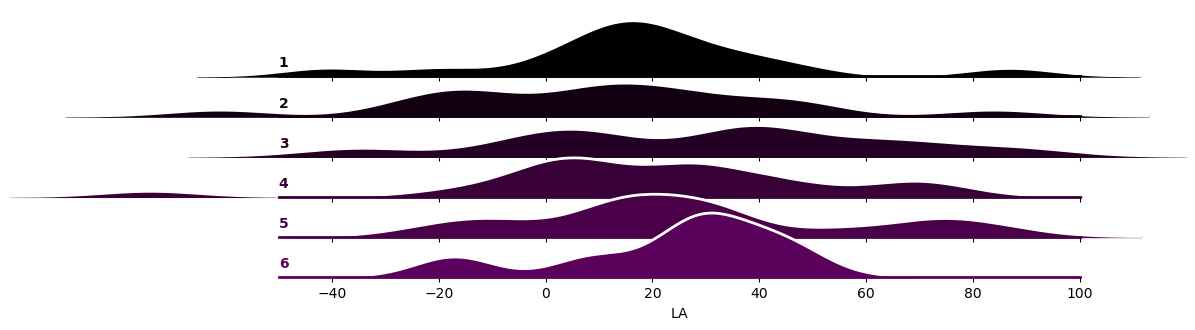

In [22]:
# Initialize the FacetGrid object
pal = sns.color_palette("blend:black,purple", n_colors=8)
g = sns.FacetGrid(goodman_fastballs, row="Day", hue="Day", aspect=15, height=0.60, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "LA",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "LA", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "LA")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-0.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Add barrel zone
for i, ax in enumerate(g.axes.flat):
    ax.set_facecolor('none')

    kde_max = 0
    for coll in ax.collections:
        if hasattr(coll, "get_paths"):
            for path in coll.get_paths():
                verts = path.vertices
                kde_max = max(kde_max, verts[:, 1].max())                
    ax.set_xlim(-50, 100)
    # ax.vlines(np.nanmean(goodman_fastballs.loc[goodman_fastballs['Day'] == i+1]['LA']), 0, kde_max, color='lightgrey', zorder=10, linewidth=2, linestyle='dotted')
    # ax.axvspan(24, 33, ymax=kde_max*20, color='silver', alpha=0.50, zorder=100, edgecolor=None)

### Beck Launch Angle

In [23]:
player_BIP_df = get_batter(BIP_df, last='Beck', first='Jordan', year=year)

# Iterate through road trips    
beck_breaking_balls = pd.DataFrame(columns=['Day', 'LA'])
for i, year_away_inds in enumerate(day_split_inds[0][1][:lim]):

    # Get home dates
    away_day_dates = year_log['Date'].to_numpy()[year_away_inds]

    # Get player dataframes for specific dates
    BIP_keep_inds = [x for x, date in enumerate(player_BIP_df['game_date'].to_list()) if date in away_day_dates]
    player_BIP_away_day_df = player_BIP_df.iloc[BIP_keep_inds]

    # Iterate through each pitch
    for j, r in player_BIP_away_day_df.iterrows():

        # Determine which pitch
        if r['pitch_name'] in (breaking_balls):
            beck_breaking_balls.loc[beck_breaking_balls.shape[0]] = [int(i+1), r['launch_speed']]

beck_breaking_balls['Day'] = beck_breaking_balls['Day'].astype(int)
beck_breaking_balls        

,Day,LA
0,1,80.3
1,1,91.0
2,1,108.2
3,1,53.1
4,1,88.6
5,1,63.1
6,2,67.4
7,2,88.0
8,2,22.9
9,2,88.3


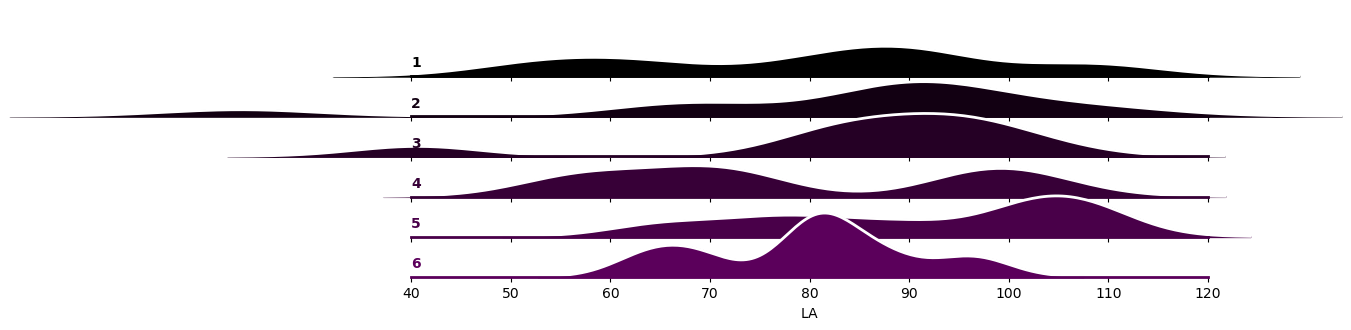

In [24]:
# Initialize the FacetGrid object
pal = sns.color_palette("blend:black,purple", n_colors=8)
g = sns.FacetGrid(beck_breaking_balls, row="Day", hue="Day", aspect=15, height=0.60, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "LA",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "LA", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "LA")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Add barrel zone
for i, ax in enumerate(g.axes.flat):
    ax.set_facecolor('none')

    kde_max = 0
    for coll in ax.collections:
        if hasattr(coll, "get_paths"):
            for path in coll.get_paths():
                verts = path.vertices
                kde_max = max(kde_max, verts[:, 1].max())                
    ax.set_xlim(40, 120)
    # ax.vlines(np.nanmean(goodman_fastballs.loc[goodman_fastballs['Day'] == i+1]['LA']), 0, kde_max, color='lightgrey', zorder=10, linewidth=2, linestyle='dotted')
    # ax.axvspan(24, 33, ymax=kde_max*20, color='silver', alpha=0.50, zorder=100, edgecolor=None)

## Tovar Fastballs

In [25]:
player_BIP_df = get_batter(BIP_df, last='Tovar', first='Ezequiel', year=year)

# Iterate through road trips    
tovar_fastballs = pd.DataFrame(columns=['Day', 'EV'])
for i, year_away_inds in enumerate(day_split_inds[0][1][:lim]):

    # Get home dates
    away_day_dates = year_log['Date'].to_numpy()[year_away_inds]

    # Get player dataframes for specific dates
    BIP_keep_inds = [x for x, date in enumerate(player_BIP_df['game_date'].to_list()) if date in away_day_dates]
    player_BIP_away_day_df = player_BIP_df.iloc[BIP_keep_inds]

    # Iterate through each pitch
    for j, r in player_BIP_away_day_df.iterrows():

        # Determine which pitch
        if r['pitch_name'] in (fastballs):
            tovar_fastballs.loc[tovar_fastballs.shape[0]] = [int(i+1), r['launch_speed']]

tovar_fastballs['Day'] = tovar_fastballs['Day'].astype(int)
tovar_fastballs        

,Day,EV
0,1,75.3
1,1,26.5
2,1,83.7
3,1,79.6
4,1,53.5
...,...,...
61,6,102.4
62,6,107.3
63,6,99.6
64,6,95.8


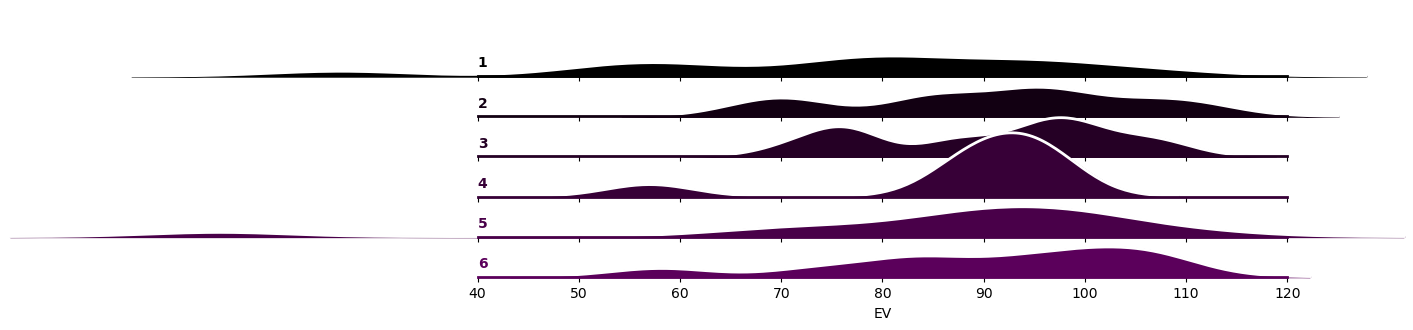

In [26]:
# Initialize the FacetGrid object
pal = sns.color_palette("blend:black,purple", n_colors=8)
g = sns.FacetGrid(tovar_fastballs, row="Day", hue="Day", aspect=15, height=0.60, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "EV",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "EV", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "EV")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.4)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Add barrel zone
for i, ax in enumerate(g.axes.flat):   
    ax.set_facecolor('none')

    ax.set_xlim(40, 120)
